In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("Ken_French_Data.csv", header=0, index_col=0, na_values=-99.99)

rets = data/100
rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')

#Paper uses excess return, therefore need to take risk-free rate off industry returns
d1 = rets
d1 = d1.drop(['Mkt-RF','RF'], 1)
d1 = d1.sub(rets['RF'], axis =0)
d1["Mkt-RF"] = rets["Mkt-RF"]

rets = d1



In [3]:
#Looks good
rets.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt-RF
Date,,,,,,,,,,,
1963-07,-0.0076,-0.0049,-0.0168,0.0202,-0.0096,-0.0050,-0.0130,0.0029,0.0053,-0.0188,-0.0039
1963-08,0.0464,0.0630,0.0595,0.0368,0.0489,0.0404,0.0618,0.0931,0.0395,0.0524,0.0507
1963-09,-0.0196,-0.0051,-0.0103,-0.0391,-0.0014,0.0209,0.0070,-0.0433,-0.0277,-0.0343,-0.0157
1963-10,0.0236,0.0943,0.0229,-0.0061,0.0800,0.0311,0.0023,0.0309,-0.0096,0.0109,0.0253
1963-11,-0.0140,-0.0511,0.0003,-0.0142,-0.0056,0.0389,-0.0150,-0.0192,-0.0129,-0.0004,-0.0085


In [4]:
def monthly_rets(r, periods_per_year=1):
#     compounded_growth = (1+r).prod()
#     n_periods = r.shape[0]
#     return compounded_growth**(periods_per_year/n_periods)-1

#     PAPER USES sample-mean to calc expected returns
    return r.mean()

def monthly_vol(r):
    #PAPER USES sample-std to calc expected vol
    #Since data is monthly, std is suffice for vol calc
    return r.std()

def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol (weights, cov):
    return (weights.T @ cov @ weights)**0.5

#Risk free rate set to 0 as the data is already excess returns
def sharpe_ratio(r, riskfree_rate= 0.0, periods_per_year=1):
    m_vol = monthly_vol(r)* np.sqrt(periods_per_year)
    sharpe = (r.mean()-riskfree_rate)/m_vol
    return sharpe

### Equal-weighted portfolio

In [5]:
def weight_ew(r):
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    return ew

In [6]:
#Example 1 to compute return for specific date:
rets.loc["2000-1"].values@weight_ew(rets).values

-0.029890909090909086

In [7]:
RW = 120

PortRet= []  
for Date,ew in rets[RW:].iterrows():
    ew = weight_ew(rets).values    
    PortRet.append(ew@rets.loc[Date].values)

Result = pd.DataFrame(PortRet, index = rets[RW:].index, columns =['ew'])

In [8]:
#Looks good
Result

,ew
Date,
1973-07,0.045464
1973-08,-0.042264
1973-09,0.048818
1973-10,-0.014973
1973-11,-0.122245
...,...
2004-07,-0.033927
2004-08,0.000464
2004-09,0.018582


In [9]:
sharpe_ratio(Result['ew'])

#Demiguel paper is 0.1353 which is fairly close

0.13649559848142276

### Mean-Variance (In-sample)

In [10]:
is_ret = rets[:120]
is_cov= rets[:120].cov()
is_er = monthly_rets(is_ret)

In [11]:
is_er

NoDur     0.003152
Durbl     0.001503
Manuf     0.003428
Enrgy     0.003761
HiTec     0.005789
Telcm    -0.000832
Shops     0.004128
Hlth      0.008325
Utils    -0.000875
Other     0.002658
Mkt-RF    0.002443
dtype: float64

In [12]:
is_cov

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt-RF
NoDur,0.001445,0.001462,0.001409,0.000983,0.001464,0.000800,0.001529,0.001256,0.000878,0.001762,0.001325
Durbl,0.001462,0.002291,0.001607,0.001199,0.001648,0.000925,0.001752,0.001241,0.000936,0.001890,0.001532
Manuf,0.001409,0.001607,0.001620,0.001025,0.001677,0.000872,0.001534,0.001359,0.000887,0.001890,0.001433
Enrgy,0.000983,0.001199,0.001025,0.001737,0.001036,0.000818,0.001106,0.000866,0.000938,0.001334,0.001146
HiTec,0.001464,0.001648,0.001677,0.001036,0.002531,0.000870,0.001704,0.001535,0.000709,0.001976,0.001554
Telcm,0.000800,0.000925,0.000872,0.000818,0.000870,0.001342,0.000945,0.000665,0.000930,0.001090,0.000918
Shops,0.001529,0.001752,0.001534,0.001106,0.001704,0.000945,0.002056,0.001298,0.000911,0.001912,0.001495
Hlth,0.001256,0.001241,0.001359,0.000866,0.001535,0.000665,0.001298,0.001630,0.000774,0.001618,0.001243
Utils,0.000878,0.000936,0.000887,0.000938,0.000709,0.000930,0.000911,0.000774,0.001327,0.001150,0.000942
Other,0.001762,0.001890,0.001890,0.001334,0.001976,0.001090,0.001912,0.001618,0.001150,0.002578,0.001762


In [41]:
def weight_func(er, cov):
    num_assets = cov.shape[0]
    inv_cov = np.linalg.inv(cov)
    opt_func = (inv_cov@er)/(np.ones((1,num_assets))@inv_cov@er)
    return opt_func

In [42]:
#Objective function/Optimizing using "Equation 3" in Dimiguel paper
opt_func = weight_func(is_er, is_cov)
opt_func
#Looks like there are no bounds in the matrix multiplication


array([  4.01928449,   3.78750236,  11.41317096,   7.25328871,
         4.48064155,   3.12593449,   4.35987036,   4.78146091,
         2.94309765,   3.44719488, -48.61144635])

In [15]:
MV_Port =[]
for Date, w in rets[:RW].iterrows():
    w = opt_func 
    MV_Port.append(w@rets.loc[Date].values)
    
MV_Port =pd.DataFrame(MV_Port, index = rets[:RW].index, 
                       columns =['mean-variance in-sample'])

In [16]:
w

array([  4.01928449,   3.78750236,  11.41317096,   7.25328871,
         4.48064155,   3.12593449,   4.35987036,   4.78146091,
         2.94309765,   3.44719488, -48.61144635])

In [17]:
sharpe_ratio(MV_Port)

mean-variance in-sample    0.566851
dtype: float64

In [18]:
MV_Port

,mean-variance in-sample
Date,
1963-07,-0.055410
1963-08,0.263382
1963-09,-0.053275
1963-10,0.062027
1963-11,-0.036226
...,...
1973-02,0.105375
1973-03,0.108594
1973-04,0.275718


### Mean-Variance Portfolio (Out-of-sample)

In [19]:
RW = 120
init_mean = rets.rolling(RW, min_periods= RW).mean().dropna()
init_cov = rets.rolling(RW, min_periods= RW).cov().dropna()

In [20]:
#Look into init_mean
init_mean = init_mean[1:]
#Weirdly enough that RW starts from June not July 
#fixing it by carrying the data to a month later
#As it shouldn't be a problem because it is rolling window estimation
init_mean

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt-RF
Date,,,,,,,,,,,
1973-07,0.003787,0.002090,0.004063,0.003567,0.006231,-0.000869,0.005102,0.008820,-0.001172,0.003560,0.002897
1973-08,0.003064,0.001181,0.003373,0.002891,0.005458,-0.001592,0.004176,0.007410,-0.001733,0.002879,0.002156
1973-09,0.003658,0.001821,0.003784,0.003933,0.005180,-0.001183,0.004681,0.007780,-0.000901,0.003708,0.002682
1973-10,0.003213,0.000606,0.003562,0.004364,0.004780,-0.001958,0.004315,0.007621,-0.001157,0.003476,0.002403
1973-11,0.002090,-0.000364,0.002305,0.003922,0.003825,-0.002491,0.002833,0.007087,-0.002063,0.002312,0.001411
...,...,...,...,...,...,...,...,...,...,...,...
2004-07,0.007222,0.004758,0.007936,0.008446,0.010810,0.001899,0.006279,0.010034,0.005160,0.008128,0.006398
2004-08,0.006808,0.004608,0.007667,0.008369,0.009691,0.001931,0.005823,0.009300,0.005433,0.008022,0.006071
2004-09,0.006710,0.005255,0.007986,0.009304,0.010027,0.002156,0.006255,0.009061,0.005804,0.008499,0.006397


In [21]:
init_cov = init_cov[11:]
init_cov

NoDur     Durbl     Manuf     Enrgy     HiTec     Telcm  \
Date                                                                         
1973-07 NoDur   0.001480  0.001497  0.001438  0.000981  0.001483  0.000795   
        Durbl   0.001497  0.002325  0.001636  0.001197  0.001667  0.000920   
        Manuf   0.001438  0.001636  0.001643  0.001025  0.001692  0.000867   
        Enrgy   0.000981  0.001197  0.001025  0.001735  0.001036  0.000819   
        HiTec   0.001483  0.001667  0.001692  0.001036  0.002541  0.000867   
...                  ...       ...       ...       ...       ...       ...   
2004-11 Shops   0.001167  0.002064  0.001729  0.000955  0.002709  0.001891   
        Hlth    0.001002  0.000914  0.000959  0.000629  0.001683  0.001307   
        Utils   0.000846  0.000710  0.000662  0.001219 -0.000039  0.000447   
        Other   0.001432  0.002187  0.001897  0.001343  0.002556  0.001926   
        Mkt-RF  0.001051  0.002018  0.001813  0.001158  0.003803  0.002223   

                   Shops     Hlth      Utils     Other    Mkt-RF  
Date                                                              
1973-07 NoDur   0.001582  0.001284  0.000862  0.001807  0.001351  
        Durbl   0.001804  0.001269  0.000921  0.001935  0.001557  
        Manuf   0.001578  0.001384  0.000874  0.001927  0.001454  
        Enrgy   0.001103  0.000864  0.000938  0.001332  0.001144  
        HiTec   0.001733  0.001551  0.000701  0.002000  0.001568  
...                  ...       ...       ...       ...       ...  
2004-11 Shops   0.002451  0.000855  0.000417  0.001855  0.001794  
        Hlth    0.000855  0.002073  0.000699  0.001299  0.001251  
        Utils   0.000417  0.000699  0.002063  0.000990  0.000539  
        Other   0.001855  0.001299  0.000990  0.002487  0.001963  
        Mkt-RF  0.001794  0.001251  0.000539  0.001963  0.002168  

[4147 rows x 11 columns]

In [22]:
Port1_weights = []
for Dates, w in init_cov.groupby(level = "Date"):
    er = init_mean.loc[Dates]
    cov = init_cov.loc[Dates,:].values
    w = weight_func(er, cov)
    
    Port1_weights.append(w)

Port1_weights 

[array([  4.06355047,   3.81143868,  11.89323485,   7.37796301,
          4.38528619,   3.1921803 ,   4.83782116,   5.07073923,
          2.70293015,   3.70535144, -50.04049547]),
 array([  4.77508666,   4.49850538,  15.25151106,   8.99123391,
          5.35502138,   3.6923338 ,   5.92547732,   5.78359991,
          3.39236996,   4.63007193, -61.2952113 ]),
 array([  4.47040978,   4.15177929,  13.65023485,   8.29464171,
          4.7007589 ,   3.28023546,   5.2870664 ,   5.31521296,
          3.18341636,   4.41039917, -55.74415487]),
 array([  4.36405883,   3.97306348,  15.74872108,   9.44875058,
          4.99175723,   3.28190314,   6.24586842,   5.8867324 ,
          3.53697487,   4.9215109 , -61.39934094]),
 array([  5.34931672,   5.27089159,  18.19891894,  11.6050361 ,
          6.18431936,   4.10390709,   7.25931328,   7.55736905,
          4.16977969,   6.32124407, -75.02009589]),
 array([  4.57989412,   5.0479665 ,  20.64416124,  12.787745  ,
          6.18586932,   4.51020493, 

In [33]:
a = np.array(Port1_weights)
a[:-1,:]

array([[  4.06355047,   3.81143868,  11.89323485, ...,   2.70293015,
          3.70535144, -50.04049547],
       [  4.77508666,   4.49850538,  15.25151106, ...,   3.39236996,
          4.63007193, -61.2952113 ],
       [  4.47040978,   4.15177929,  13.65023485, ...,   3.18341636,
          4.41039917, -55.74415487],
       ...,
       [  0.51477104,  -0.38837444,   1.44865225, ...,   0.14561833,
          1.44073335,  -6.19892278],
       [  0.3887445 ,  -0.34853401,   1.2987206 , ...,   0.14417445,
          1.42155668,  -5.78798276],
       [  0.42614887,  -0.37569144,   1.21254205, ...,   0.22432906,
          1.42910396,  -5.66203226]])

In [36]:
Port1_weights = pd.DataFrame(Port1_weights, index= rets[RW:].index, 
                             columns = list(init_mean))
Port1_weights

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt-RF
Date,,,,,,,,,,,
1973-07,4.063550,3.811439,11.893235,7.377963,4.385286,3.192180,4.837821,5.070739,2.702930,3.705351,-50.040495
1973-08,4.775087,4.498505,15.251511,8.991234,5.355021,3.692334,5.925477,5.783600,3.392370,4.630072,-61.295211
1973-09,4.470410,4.151779,13.650235,8.294642,4.700759,3.280235,5.287066,5.315213,3.183416,4.410399,-55.744155
1973-10,4.364059,3.973063,15.748721,9.448751,4.991757,3.281903,6.245868,5.886732,3.536975,4.921511,-61.399341
1973-11,5.349317,5.270892,18.198919,11.605036,6.184319,4.103907,7.259313,7.557369,4.169780,6.321244,-75.020096
...,...,...,...,...,...,...,...,...,...,...,...
2004-07,0.621043,-0.336605,1.371078,0.602356,1.784419,-0.056490,0.580367,1.397053,0.090301,1.435724,-6.489247
2004-08,0.514771,-0.388374,1.448652,0.530327,1.673760,-0.030981,0.517075,1.347341,0.145618,1.440733,-6.198923
2004-09,0.388744,-0.348534,1.298721,0.597651,1.554802,-0.048719,0.536864,1.242722,0.144174,1.421557,-5.787983


In [25]:
PortRet1=[]
for Date, w in rets[RW:].iterrows():
    w = Port1_weights.loc[Date].values     
    PortRet1.append(w@rets.loc[Date].values)
    
PortRet1 =pd.DataFrame(PortRet1, index = rets[RW:].index, 
                       columns =['mean-variance out-of-sample'])

<AxesSubplot:title={'center':'Industry Portfolios'}, xlabel='Date'>

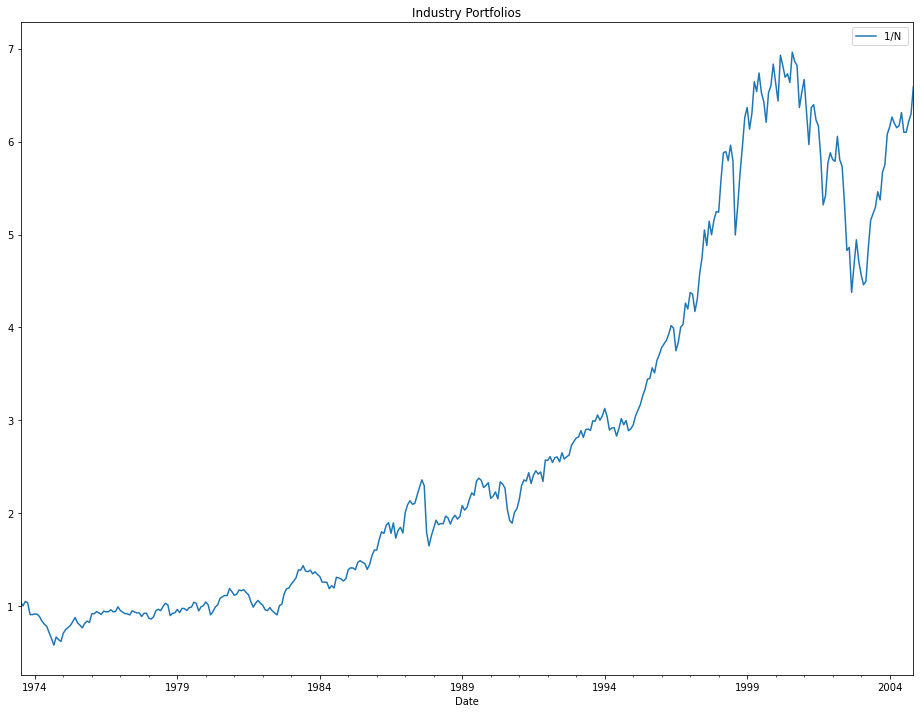

In [27]:
btr = pd.DataFrame({"1/N ": Result["ew"],
#                    "MV (OoS)": PortRet1["mean-variance out-of-sample"],
#                    "MV (IS)": MV_Port['mean-variance in-sample'],              
                   })
(1+btr).cumprod().plot(figsize=(16,12), title="Industry Portfolios")


<AxesSubplot:title={'center':'Industry Portfolios'}, xlabel='Date'>

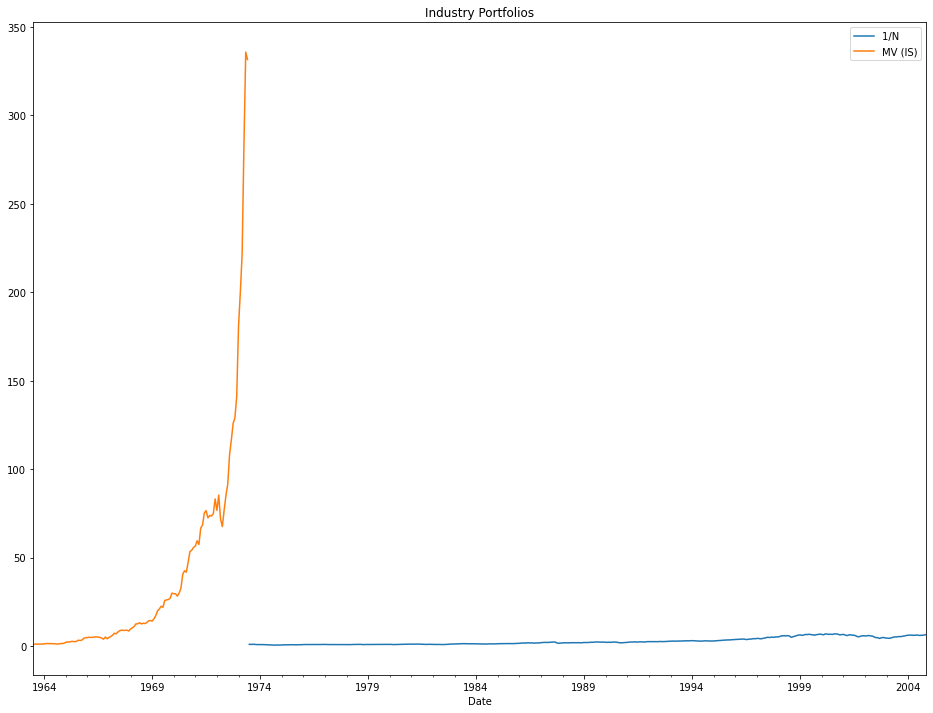

In [37]:
btr = pd.DataFrame({"1/N ": Result["ew"],
                   #"MV (OoS)": PortRet1["mean-variance out-of-sample"],
                   "MV (IS)": MV_Port['mean-variance in-sample'],              
                   })
(1+btr).cumprod().plot(figsize=(16,12), title="Industry Portfolios")
